# Distracted driver detection
<br>這是一個Kaggle上面的題目：https://www.kaggle.com/c/state-farm-distracted-driver-detection</br>
<br>目的是為了預測圖片上的司機是否有在安全駕駛，圖片的資料原本是RGB，首先用python套件把資料轉換成Grayscale之後再利用PySpark分析</br>

In [62]:
%pylab inline
import os,cv2,glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Import Pyspark

In [2]:
#在Notebook上把spark import進來
import sys

os.environ['SPARK_HOME']="C:/spark-1.6.1/" #看spark在你電腦的path是在哪裡

sys.path.append("C:/spark-1.6.1/bin") 
sys.path.append("C:/spark-1.6.1/python")
sys.path.append("C:/spark-1.6.1/python/pyspark/")
sys.path.append("C:/spark-1.6.1/python/lib") 
sys.path.append("C:/spark-1.6.1/python/lib/pyspark.zip")
sys.path.append("C:/spark-1.6.1/python/lib/py4j-0.9-src.zip")
exec(open("C:/spark-1.6.1/python/pyspark/shell.py").read())

import pyspark
from pyspark import SparkConf,SparkContext
#conf = SparkConf().setAppName('driver_distraction_detect').setMaster('local')
#sc = SparkContext(conf=conf)
#sqlContext = pyspark.sql.SQLContext(sc) #DataFrame需要用到的SQL context

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.1
      /_/

Using Python version 2.7.11 (default, Feb 16 2016 09:58:36)
SparkContext available as sc, SQLContext available as sqlContext.


## Import necessary libraries

In [13]:
import pyspark.mllib
import pyspark.mllib.regression
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.sql.functions import *
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.tree import DecisionTree, RandomForest, RandomForestModel
from pyspark.mllib.evaluation import MulticlassMetrics

In [114]:
img_rows, img_cols = 48,64

In [64]:
def get_image(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    edges = cv2.Canny(resized, 90, 250)
    return edges

In [116]:
a = get_image('C:/Users/Jing Kai/Desktop/Ipython/Kaggle/Driver/sample/train/c0/img_5605.jpg',img_rows,img_cols)

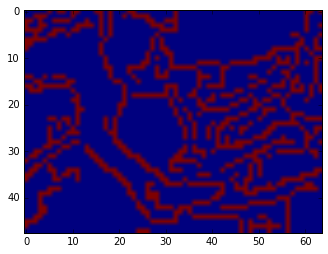

In [137]:
plt.imshow(a)

In [121]:
unique(a)

array([  0, 255], dtype=uint8)

In [119]:
shape(a)

(48L, 64L)

In [44]:
def load_train(img_rows, img_cols, color_type=1):
    X_train = []

    print('Read train images...')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('C:/Users/Jing Kai/Desktop/Ipython/Kaggle/Driver/sample/', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            #loading img by cv2
            flbase = os.path.basename(fl)
            img = get_image(fl, img_rows, img_cols, color_type)
            
            #reshape image
            dims = shape(img)
            img_data= np.reshape(img, (1,dims[0] * dims[1]))[0]
            img_data = list(img_data.astype('float') / 255.)
            
            #label the features that have value for sparse vector
            num_of_features = len(img_data)
            indices_of_sparsedata = [i for i,x in enumerate(img_data) if x != 0]
            values_of_sparsedata = [img_data[i] for i in indices_of_sparsedata]
            
            X_train.append(LabeledPoint(double(j),
                                        SparseVector(num_of_features,indices_of_sparsedata,values_of_sparsedata)))
            
    return X_train

## Data Loading

In [45]:
X_train = load_train(img_rows,img_cols)

Read train images...
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9


In [46]:
data = sc.parallelize(X_train)

In [123]:
data.first().features

SparseVector(3072, {11: 1.0, 12: 1.0, 13: 1.0, 20: 1.0, 23: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 78: 1.0, 79: 1.0, 84: 1.0, 87: 1.0, 114: 1.0, 115: 1.0, 116: 1.0, 121: 1.0, 122: 1.0, 128: 1.0, 129: 1.0, 130: 1.0, 131: 1.0, 143: 1.0, 144: 1.0, 148: 1.0, 151: 1.0, 154: 1.0, 155: 1.0, 156: 1.0, 157: 1.0, 158: 1.0, 181: 1.0, 182: 1.0, 183: 1.0, 200: 1.0, 201: 1.0, 206: 1.0, 208: 1.0, 212: 1.0, 213: 1.0, 216: 1.0, 223: 1.0, 248: 1.0, 249: 1.0, 258: 1.0, 259: 1.0, 260: 1.0, 261: 1.0, 273: 1.0, 277: 1.0, 280: 1.0, 282: 1.0, 283: 1.0, 284: 1.0, 285: 1.0, 307: 1.0, 308: 1.0, 314: 1.0, 315: 1.0, 316: 1.0, 328: 1.0, 335: 1.0, 337: 1.0, 341: 1.0, 342: 1.0, 345: 1.0, 373: 1.0, 374: 1.0, 375: 1.0, 381: 1.0, 383: 1.0, 392: 1.0, 394: 1.0, 395: 1.0, 396: 1.0, 402: 1.0, 406: 1.0, 409: 1.0, 439: 1.0, 440: 1.0, 442: 1.0, 446: 1.0, 447: 1.0, 454: 1.0, 455: 1.0, 456: 1.0, 457: 1.0, 461: 1.0, 464: 1.0, 466: 1.0, 470: 1.0, 473: 1.0, 507: 1.0, 510: 1.0,

## Model Training

In [47]:
training_data, testing_data = data.randomSplit([0.8, 0.2], seed=0)

model = DecisionTree.trainClassifier(training_data, numClasses=10, maxDepth=2,
                                     categoricalFeaturesInfo={},
                                     impurity='gini', maxBins=32)

print model.toDebugString()

DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 2959 <= 0.0)
   If (feature 1846 <= 0.0)
    Predict: 2.0
   Else (feature 1846 > 0.0)
    Predict: 3.0
  Else (feature 2959 > 0.0)
   If (feature 1093 <= 0.0)
    Predict: 7.0
   Else (feature 1093 > 0.0)
    Predict: 7.0



## Model Evaluation

In [48]:
def printMetrics(model, test_data):
   
    predictionAndLabels = test_data.map(lambda data: (float(model.predict(data.features)), float(data.label)))
    metrics = MulticlassMetrics(predictions_and_labels)
    labels = test_data.map(lambda lp: lp.label).distinct().collect()
    
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print "Confusion Matrix\n", metrics.confusionMatrix().toArray()

In [49]:
printMetrics(model, testing_data)

Class 0.0 precision = 0.0
Class 0.0 recall = 0.0
Class 0.0 F1 Measure = 0.0
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.117130307467
Class 2.0 recall = 0.952380952381
Class 2.0 F1 Measure = 0.208604954368
Class 3.0 precision = 0.181318681319
Class 3.0 recall = 0.358695652174
Class 3.0 F1 Measure = 0.240875912409
Class 4.0 precision = 0.0
Class 4.0 recall = 0.0
Class 4.0 F1 Measure = 0.0
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
Class 6.0 precision = 0.0
Class 6.0 recall = 0.0
Class 6.0 F1 Measure = 0.0
Class 7.0 precision = 0.485714285714
Class 7.0 recall = 0.215189873418
Class 7.0 F1 Measure = 0.298245614035
Class 8.0 precision = 0.0
Class 8.0 recall = 0.0
Class 8.0 F1 Measure = 0.0
Class 9.0 precision = 0.0
Class 9.0 recall = 0.0
Class 9.0 F1 Measure = 0.0
Confusion Matrix
[[  0.   0.  48.  42.   0.   0.   0.   1.   0.   0.]
 [  0.   0.  87.   6.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  80.  

## Model Selection
The ML package needs data be put in a (label: Double, features: Vector) DataFrame format with correspondingly named fields. The vectorizeData() function below performs this formatting.

In [50]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [103]:
from pyspark.ml.classification import MultilayerPerceptronClassifier,RandomForestClassifier,NaiveBayes,LogisticRegression

In [104]:
?LogisticRegression

In [87]:
RF = RandomForest()

In [93]:
model = RandomForest.trainClassifier(training_data, numClasses=10, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)

In [ ]:
def model_select(data, model_family):
    

In [70]:
vectorizedData = training_data.toDF()

In [72]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(vectorizedData)

In [73]:
# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures').fit(vectorizedData)

In [89]:
?VectorIndexer()

In [74]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [76]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')    

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorizedData)

# Fetch best model
tree_model = CV_model.bestModel.stages[2]
print tree_model

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_49639afa22eda0631b56) of depth 7 with 151 nodes


In [79]:
vectorized_test_data = testing_data.toDF()

transformed_data = CV_model.transform(vectorized_test_data)
print evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data)

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.294189402444


,indexedLabel,prediction,probability
0,8.0,0.0,"[0.470588235294, 0.0196078431373, 0.0196078431..."
1,8.0,6.0,"[0.121212121212, 0.047619047619, 0.00432900432..."
2,8.0,3.0,"[0.0901639344262, 0.139344262295, 0.0573770491..."
3,8.0,5.0,"[0.0754716981132, 0.0188679245283, 0.056603773..."
4,8.0,7.0,"[0.120843471208, 0.0729927007299, 0.0762368207..."


In [105]:
crossval.explainParams()

"estimator: estimator to be cross-validated (current: Pipeline_4f12ab761013d0c69bd3)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='DecisionTreeClassifier_49639afa22eda0631b56', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2}, {Param(parent='DecisionTreeClassifier_49639afa22eda0631b56', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3}, {Param(parent='DecisionTreeClassifier_49639afa22eda0631b56', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 4}, {Param(parent='DecisionTreeClassifier_49639afa22eda0631b56', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}, {Param(parent='DecisionTreeClassifier_49639afa22ed